![Python Logo](../../assets/images/python-logo-master-v3-TM.png)

# <center> Exploratory Data Analysis for AskUbuntu Question Data </center>
### <center> Shagun Sodhani </center>

In [1]:
# put in the name of the Stack Exchange Site which you want to analyse.
data_source = "AskUbuntu"
data_type = "Question"
base_url = "http://askubuntu.com/questions/"

### Before we dive into the code, lets see the script which I used to run the notebook.

In [2]:
!cat run.sh

cat: run.sh: No such file or directory


**PYSPARK_DRIVER_PYTHON=jupyter**

This sets the driver as this Jupyter Notebook

**PYSPARK_DRIVER_PYTHON_OPTS="notebook"**

This is used to pass options when starting the Python driver

**$SPARK_HOME/bin/pyspark --master local[2]**

This runs a pyspark shell in local mode with 2 executors.

## Let us begin

### We will import everything in one cell for the sake for reference.

In [3]:
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd
from time import time
import operator
%matplotlib inline
from __future__ import print_function

### Notice that we did not import sparkcontext or sqlContext. They are already created for us to use.

### Check if SparkContext and SQLContext have been created.

In [4]:
if('sc' in locals() or 'sc' in globals()):
    print("SparkContext is defined.")
else:
    print("SparkContext does not exist.")

SparkContext is defined.


In [5]:
if('sqlContext' in locals() or 'sqlContext' in globals()):
    print("SQLContext is defined.")
else:
    print("SQLContext does not exist.")

SQLContext is defined.


### Now let us load the question data as a dataframe. Since we will be using this data many times, we will cache it in memory.

In [6]:
start_time = time()
print ("data_source =", data_source)
print ("data_type =", data_type)
question_data_path = "../../data/"+data_source+"/"+data_type
print (question_data_path)
question_df = sqlContext.read.load(question_data_path).cache()
print ("Time taken =", time() - start_time, "seconds.")

data_source = AskUbuntu
data_type = Question
../../data/AskUbuntu/Question
Time taken = 14.9845690727 seconds.


### *sqlContext.read.load(question_data_path)* tells the master to load the data written in *question_data_path* as a parquet file (default choice for data format).

### *cache()* tells the master to cache the data in the main memory for faster operations.

## <center> DataFrame </center>

### A DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.

### Since DataFrame organizes the data into a relational view (rows and columns), it has a schema associated with it.

In [7]:
print("Schema for question dataframe")
question_df.printSchema()

Schema for question dataframe
root
 |-- Id: long (nullable = true)
 |-- AcceptedAnswerId: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Score: long (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- LastEditorUserId: long (nullable = true)
 |-- LastEditorDisplayName: string (nullable = true)
 |-- LastEditDate: string (nullable = true)
 |-- LastActivityDate: string (nullable = true)
 |-- CommunityOwnedDate: string (nullable = true)
 |-- ClosedDate: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- FavoriteCount: long (nullable = true)



### Some common metrics for this data

In [8]:
number_of_rows = question_df.count()
print("Total number of rows in the data = " + str(number_of_rows))

Total number of rows in the data = 230177


In [9]:
number_of_unique_ids = question_df.select('Id').distinct().count()
print("Total number of unique Id in the data = " + str(number_of_unique_ids))

Total number of unique Id in the data = 230177


In [10]:
max_score = question_df.agg({"Score": "max"}).collect()[0][0]
print("Maximum score for a question = " + str(max_score))

Maximum score for a question = 816


In [11]:
max_view_count = question_df.agg({"ViewCount": "max"}).collect()[0][0]
print("Maximum Views for a question = " + str(max_view_count))

Maximum Views for a question = 1858449


### Alternatively, we could use the *describe* method to get all these statistics in one go.

In [12]:
question_df.describe().toPandas()

,summary,Id,AcceptedAnswerId,Score,ViewCount,OwnerUserId,LastEditorUserId,AnswerCount,CommentCount,FavoriteCount
0,count,230177,230177,230177,230177,230177,230177,230177,230177,230177
1,mean,417469.9902292584,119929.5281022865,2.3002081007224873,3284.9998522875876,211746.15972925184,81897.8957888929,1.3115732675289016,1.5561763338648085,0.7196852856714615
2,stddev,238951.3966121841,216818.10120712678,9.308674698855008,19168.20085581637,169306.2791769559,131869.5363577083,1.3296007254042488,2.3816048503899383,4.68373344154214
3,min,1,-1,-18,2,-2,-2,0,0,0
4,max,785926,785922,816,1858449,556130,556082,78,61,591


### Disclaimer - Pandas is used only for visualising the processed data in tabular form as Jupyter notebooks visualise Pandas dataframes very nicely. All the processing is being done by Spark.

In [13]:
question_df.select('Tags').show(truncate = False)

+--------------------------------------------+
|Tags                                        |
+--------------------------------------------+
|<updates><unattended-upgrades>              |
|<wallpaper><artwork><photography>           |
|<package-management><uninstall>             |
|<command-line><package-management>          |
|<ntp>                                       |
|<applet><panel><networking>                 |
|<metacity><window-buttons>                  |
|<wine><browser><ie>                         |
|<thunderbird><google-calendar><calendar>    |
|<firewall>                                  |
|<windows><wubi><system-installation>        |
|<derivatives>                               |
|<software-recommendation><command-line><irc>|
|<kernel><hibernate><suspend><fan><bios>     |
|<server><security>                          |
|<video><mythtv>                             |
|<community>                                 |
|<10.04><encryption><home-directory>         |
|<sound>     

### Let us find the question with maximum score.

In [14]:
question_max_score = question_df.filter("Score = "+str(max_score)).select('Id').collect()[0][0]
question_df.filter("Score = "+str(max_score)).toPandas()

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,17823,17829,2010-12-17T02:08:49.860,816,1227006,<p>I'd like to output a list of all installed ...,2390,527350,,,2016-06-08T17:48:09.217,,,How to list all installed packages,<apt><package-management>,18,2,430


##  <center> Lazy Evaluation </center>

Spark Dataframes and RDDs are lazy. They do nothing unless an action is called. We can keep adding as many transformations as we want but nothing actually happens till we call an action. By deferring evaluations, Spark can optimise the overall workflow as it evaluates only that which is needed.

In [15]:
start_time = time()
question_max_score = question_df.orderBy("Score", desc=True)
print (question_max_score)
print ("Time taken =", time() - start_time, "seconds.")

DataFrame[Id: bigint, AcceptedAnswerId: bigint, CreationDate: string, Score: bigint, ViewCount: bigint, Body: string, OwnerUserId: bigint, LastEditorUserId: bigint, LastEditorDisplayName: string, LastEditDate: string, LastActivityDate: string, CommunityOwnedDate: string, ClosedDate: string, Title: string, Tags: string, AnswerCount: bigint, CommentCount: bigint, FavoriteCount: bigint]
Time taken = 0.016499042511 seconds.


In [16]:
start_time = time()
list_question_max_score = question_df.orderBy("Score", desc=True).take(1000)
print ("Size of list =",len(list_question_max_score))
print ("Time taken =", time() - start_time, "seconds.")

Size of list = 1000
Time taken = 5.66676282883 seconds.


In [17]:
start_time = time()
list_question_max_score = question_df.orderBy("Score", desc=True).take(1)
print ("Size of list =",len(list_question_max_score))
print ("Time taken =", time() - start_time, "seconds.")

Size of list = 1
Time taken = 3.70635890961 seconds.


### Lazy is better than eager.

### We can find the question with maximum score, view count, answer count, comment count and favorite count.

In [18]:
start_time = time() 
column_list = ["Score", "ViewCount", "AnswerCount", "CommentCount", "FavoriteCount"]

for col in column_list:
    max_value_col = question_df.orderBy(col, ascending=False).select("Id", col).take(1)[0]
    questionId = str(max_value_col[0])
    print ("max", col, "value =",str(max_value_col[1]),"for questionId =", questionId, "", base_url+questionId, "\n")
print ("Time taken =", time() - start_time, "seconds.")

max Score value = 816 for questionId = 17823  http://askubuntu.com/questions/17823 

max ViewCount value = 1858449 for questionId = 25961  http://askubuntu.com/questions/25961 

max AnswerCount value = 78 for questionId = 30334  http://askubuntu.com/questions/30334 

max CommentCount value = 61 for questionId = 555519  http://askubuntu.com/questions/555519 

max FavoriteCount value = 591 for questionId = 56104  http://askubuntu.com/questions/56104 

Time taken = 4.47453784943 seconds.


###  Before using any algorithm from Spark Machine Learning (ml and MLlib), we transform this data to a collection of vectors. While parsing the raw xml files, I used certain default values (in place of missing values). We will filter for those values now.

In [19]:
filter_expression = "ViewCount > -1 and AnswerCount > -1 and CommentCount > -1 and FavoriteCount > -1"
vectorData = question_df.filter(filter_expression)\
.select(column_list)\
.map(lambda data: Vectors.dense([c for c in data]))

### *vectorData* consists of rows, where each row is a vector of data we selected above. 

In [20]:
print (vectorData)
vectorData.take(5)

PythonRDD[130] at RDD at PythonRDD.scala:43


[DenseVector([88.0, 44595.0, 5.0, 1.0, 27.0]),
 DenseVector([16.0, 641.0, 1.0, 2.0, 2.0]),
 DenseVector([11.0, 3571.0, 3.0, 1.0, 2.0]),
 DenseVector([147.0, 26759.0, 6.0, 1.0, 40.0]),
 DenseVector([17.0, 37191.0, 3.0, 1.0, 10.0])]

### Calculating basic statistics about the data

In [21]:
print ("Columns in vectorData are",column_list)
stats = Statistics.colStats(vectorData)
for col, val in zip(column_list, stats.mean()):
    print ("Average ", col, " = ", val)

Columns in vectorData are ['Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount']
Average  Score  =  2.30020810072
Average  ViewCount  =  3284.99985229
Average  AnswerCount  =  1.31157326753
Average  CommentCount  =  1.55617633386
Average  FavoriteCount  =  0.719685285671


Other supported statistics include:
    * count()
    * max()
    * mean()
    * min()
    * normL1()
    * normL2()
    * numNonzeros()
    * variance()

For the sake of completeness, we will try all these methods. We would visualise this data as Pandas dataframe to make it look clean

In [22]:
pd_data = map(list, [[stats.count()]*5, stats.max(), stats.mean(), stats.min(), stats.normL1(), stats.normL2(),\
           stats.numNonzeros() ,stats.variance()])
pd_index = ['Count', 'Max', 'Mean', 'Min', 'NormL1', 'NormL2', 'NumNonzeros', 'Variance']
pd.DataFrame(pd_data, index=pd_index, columns=column_list)

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
Count,230177.000000,2.301770e+05,230177.000000,230177.000000,230177.000000
Max,816.000000,1.858449e+06,78.000000,61.000000,591.000000
Mean,2.300208,3.285000e+03,1.311573,1.556176,0.719685
Min,-18.000000,2.000000e+00,0.000000,0.000000,0.000000
NormL1,546143.000000,7.561314e+08,301894.000000,358196.000000,165655.000000
NormL2,4600.319011,9.330334e+06,896.030133,1364.911719,2273.471574
NumNonzeros,136137.000000,2.301770e+05,182157.000000,121935.000000,55770.000000
Variance,86.651425,3.674199e+08,1.767838,5.672042,21.937359


### We will calculate correlation between each pair of columns and see if we find some thing interesting.

In [23]:
start_time = time()
Statistics.colStats(vectorData)
pd_data = Statistics.corr(vectorData, method="pearson")
pd.DataFrame(pd_data, index=column_list, columns=column_list)
print ("Time taken =", time() - start_time, "seconds.")
pd.DataFrame(pd_data, index=column_list, columns=column_list)

Time taken = 5.76436591148 seconds.


,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
Score,1.000000,0.756401,0.464259,0.026297,0.880058
ViewCount,0.756401,1.000000,0.381177,0.019424,0.692194
AnswerCount,0.464259,0.381177,1.000000,0.014119,0.435823
CommentCount,0.026297,0.019424,0.014119,1.000000,0.028963
FavoriteCount,0.880058,0.692194,0.435823,0.028963,1.000000


### Some observations:
    High positive correlation between Score and ViewCount (0.75).
    
    Very high positive correlation between Score and FavoriteCount (0.88).
    
    High positive correlation between FavoriteCount and ViewCount (0.69).

All these observations are explainable as the three correlating metrics - Score, ViewCount and FavoriteCount are expected to behave similarly. Let us explore the plot of Score and FavoriteCount.

We filter the data to contain only Score and FavoriteCount and filter for rows with defualt values

In [24]:
columns_to_select = ["Score", "FavoriteCount"]
data = question_df.filter(filter_expression).select(columns_to_select).cache()
data.sample(False, 0.0001, 42).toPandas()

,Score,FavoriteCount
0,0,0
1,9,2
2,2,0
3,8,1
4,3,0
5,1,1
6,0,0
7,-1,0
8,0,1
9,3,0


Notice that this is the second dataframe that we have cached so far.

We can check the memory profile for the app at http://localhost:4040/storage.

Let us try unpersisting *question_df* dataframe and see if we can recover some memory.

In [25]:
question_df.unpersist()

DataFrame[Id: bigint, AcceptedAnswerId: bigint, CreationDate: string, Score: bigint, ViewCount: bigint, Body: string, OwnerUserId: bigint, LastEditorUserId: bigint, LastEditorDisplayName: string, LastEditDate: string, LastActivityDate: string, CommunityOwnedDate: string, ClosedDate: string, Title: string, Tags: string, AnswerCount: bigint, CommentCount: bigint, FavoriteCount: bigint]

Check that now only one dataframe is cached for the application. http://localhost:4040/storage.

Spark is good at number chrunching and performing compuations but not so good at visualisations. So we will load a sample of the dataset into Pandas dataframe using the toPandas method and visualise it using sns.

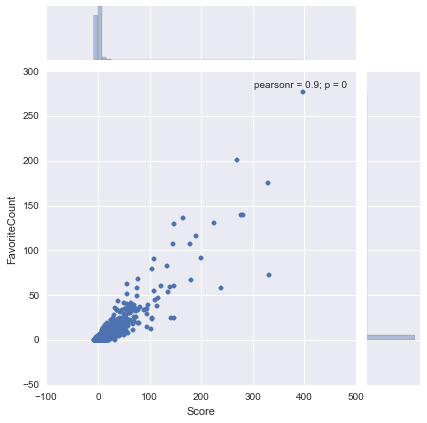

In [26]:
pandas_df = data.sample(False, .1, 42).toPandas()
# %matplotlib qt
sns.jointplot(columns_to_select[0], columns_to_select[1], data=pandas_df)

Time taken = 0.446715831757 seconds.


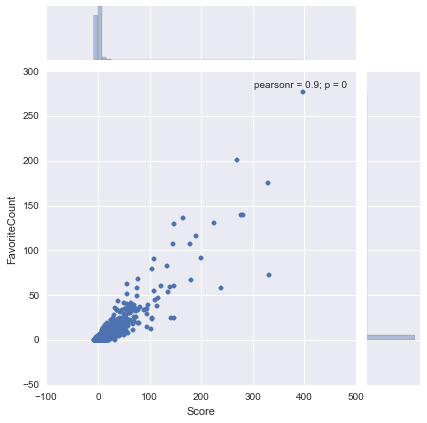

In [27]:
start_time = time()
pandas_df = data.sample(False, .1, 42).toPandas()
%matplotlib inline
sns.jointplot(columns_to_select[0], columns_to_select[1], data=pandas_df)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 1.94435501099 seconds.


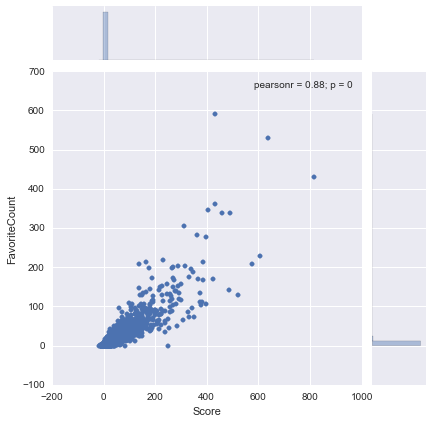

In [28]:
start_time = time()
pandas_df = data.sample(False, .99, 42).toPandas()
%matplotlib inline
sns.jointplot(columns_to_select[0], columns_to_select[1], data=pandas_df)
print ("Time taken =", time() - start_time, "seconds.")

This visualistion is unintutive as most of the data is distributed in a narrow zone and the 
scale is skewed due to outliers. We will try plotting the values on the log scale.

['LOG10(Score)', 'LOG10(FavoriteCount)']


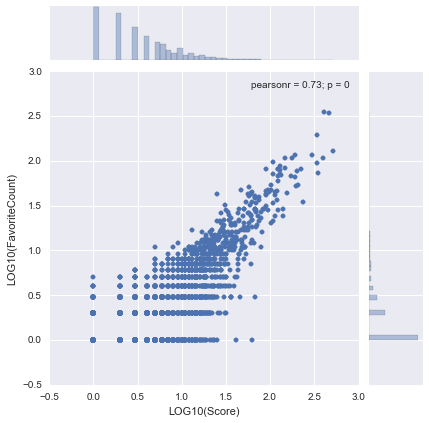

In [29]:
log_pandas_df = data.select(func.log10(data[columns_to_select[0]]),\
                            func.log10(data[columns_to_select[1]])).sample(False, .1).toPandas()
# %matplotlib qt
modified_columns_to_select = map(lambda a: "LOG10("+a+")", columns_to_select)
print (modified_columns_to_select)
sns.jointplot(modified_columns_to_select[0], modified_columns_to_select[1], data=log_pandas_df)

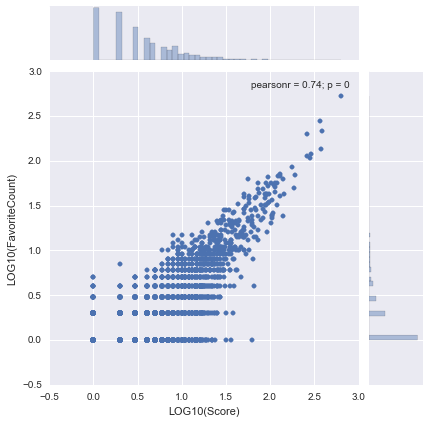

In [30]:
log_pandas_df = data.select(func.log10(data[columns_to_select[0]]),\
                            func.log10(data[columns_to_select[1]])).sample(False, .1).toPandas()
%matplotlib inline
sns.jointplot(modified_columns_to_select[0], modified_columns_to_select[1], data=log_pandas_df)

Before we wrap up, let us play with the *CreationDate* column and see if we can mine some interesting observations on that front. The idea is to show how we can play with more complex data types (like datetime)and use some Spark operators as well.

We will start with the *question_df* dataframe. Remember that we had uncached it which means it is no longer available in memory but we can still run operations on it. In this case, the dataframe would be loaded once again but will not be persisted, unless we explicitly ask Spark to do so.

In [31]:
creation_date_df = question_df.select("CreationDate").cache()
creation_date_df.printSchema()
creation_date_df.show(10)

root
 |-- CreationDate: string (nullable = true)

+--------------------+
|        CreationDate|
+--------------------+
|2010-07-28T19:26:...|
|2010-07-28T19:46:...|
|2010-07-28T20:11:...|
|2010-07-28T21:49:...|
|2010-07-29T00:01:...|
|2010-07-29T06:50:...|
|2010-07-29T12:09:...|
|2010-07-29T18:53:...|
|2010-07-30T14:21:...|
|2010-07-31T15:20:...|
+--------------------+
only showing top 10 rows



Note that **CreationDate** column was parsed as **string**. Let us fix that by selecting **CreationDate** as **date** type.

In [32]:
date_df = creation_date_df.select(func.to_date(creation_date_df["CreationDate"]).alias("CreationDate"))
date_df.printSchema()
date_df.show(10)

root
 |-- CreationDate: date (nullable = true)

+------------+
|CreationDate|
+------------+
|  2010-07-28|
|  2010-07-28|
|  2010-07-28|
|  2010-07-28|
|  2010-07-29|
|  2010-07-29|
|  2010-07-29|
|  2010-07-29|
|  2010-07-30|
|  2010-07-31|
+------------+
only showing top 10 rows



### RDD vs DataFrame

We want to count the number of new accounts each day. We would try doing this using both RDDs and DataFrames and compare their performance.

### RDD
We want to count the number of new accounts added each day. We first convert our dataframe to rdd. In  data, each row corresponds to one account. So each row contributes one new account. We map each row with neumerical value 1 (number of accounts each row contributes).

Then we reduce our data using date as the key and add the values corresponding to same date.

In [33]:
start_time = time()
aggregated_df = date_df.rdd.map(lambda a: (a, 1)).reduceByKey(operator.add).toDF()
print ("aggregated_df maps each date to number of accounts that were created.")
print ("Number of rows = ",aggregated_df.count())
time_taken_rdd = time() - start_time
print ("Time taken =", time_taken_rdd, "seconds.")

aggregated_df maps each date to number of accounts that were created.
Number of rows =  2152
Time taken = 2.13794398308 seconds.


### DataFrame

In [34]:
start_time = time()
aggregated_df = date_df.groupBy('CreationDate').count()
print ("aggregated_df maps each date to number of accounts that were created.")
print ("Number of rows = ",aggregated_df.count())
time_taken_df = time() - start_time
print ("Time taken =", time_taken_df, "seconds.")

aggregated_df maps each date to number of accounts that were created.
Number of rows =  2152
Time taken = 1.38895702362 seconds.


In [35]:
print ("time_taken_rdd =", time_taken_rdd)
print ("time_taken_df =", time_taken_df)
print ("Speed up =",time_taken_rdd/time_taken_df)

time_taken_rdd = 2.13794398308
time_taken_df = 1.38895702362
Speed up = 1.53924415711


### DataFrames are many times faster than RDDs.

In [36]:
aggregated_df.printSchema()

root
 |-- CreationDate: date (nullable = true)
 |-- count: long (nullable = false)



In [37]:
question_creationdate_df = aggregated_df.select("CreationDate", aggregated_df["count"].alias("NewQuestions"))\
.orderBy(func.asc("CreationDate"))
pandas_df = question_creationdate_df.toPandas()
pandas_df

,CreationDate,NewQuestions
0,2009-01-08,1
1,2009-02-03,1
2,2009-07-22,1
3,2009-12-26,1
4,2010-05-01,1
5,2010-07-28,70
6,2010-07-29,55
7,2010-07-30,20
8,2010-07-31,14
9,2010-08-01,13


Let us plot this data and see if there is any interesting observation.

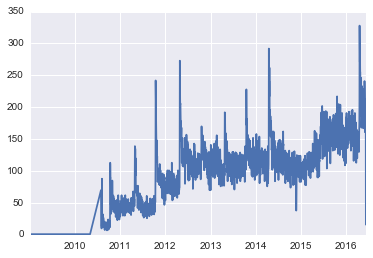

In [38]:
# %matplotlib qt
plt.plot(pandas_df.CreationDate, pandas_df.NewQuestions)

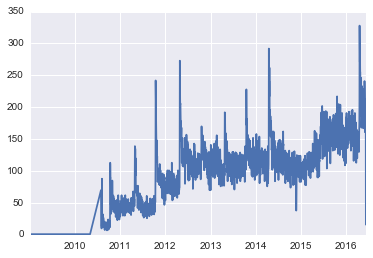

In [39]:
%matplotlib inline
plt.plot(pandas_df.CreationDate, pandas_df.NewQuestions)

### Observations:

It seems we have some nosiy data for the first few days. If we go back to the table we have 3 cells above, we will see that the first few days are infact far apart. Probably that data corresponds to site activity during testing as we know that [AskUbuntu went into public beta 10 October 2010, alongside Ubuntu 10.10](http://blog.stackoverflow.com/2010/10/ubuntu-stack-exchange-is-askubuntu-com/) 

The peaks occur close to release dates of new versions of Ubuntu. The only major dip occurred on 26th November 2014 when less than 40 questions were posted on the site. I do not know the reason for the same.

This graph seems to be similar to the graph we had for new accounts created each day. Let us pull in that data and plot the 2 graphs together.

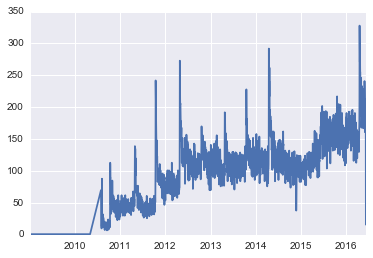

In [40]:
%matplotlib inline
plt.plot(pandas_df.CreationDate, pandas_df.NewQuestions)

In [42]:
user_data_path = "../../data/"+data_source+"/User"
user_creation_date_df = sqlContext.read.load(user_data_path).select(func.to_date("CreationDate")\
                        .alias("CreationDate")).groupBy('CreationDate').count()\
                        .withColumnRenamed("count", "NewAccounts")
user_creation_date_df

DataFrame[CreationDate: date, NewAccounts: bigint]

In [43]:
start_time = time()
joined_data_df = question_creationdate_df.join(user_creation_date_df, \
              aggregated_df["CreationDate"] == user_creation_date_df["CreationDate"])\
              .drop(user_creation_date_df["CreationDate"])\
              .cache()
pd_joined_data_df = joined_data_df.toPandas()
joined_data_df.show(10)
print ("Time taken =", time() - start_time, "seconds.")

+------------+------------+-----------+
|CreationDate|NewQuestions|NewAccounts|
+------------+------------+-----------+
|  2010-08-10|          18|         21|
|  2011-02-26|          42|         21|
|  2011-09-14|          56|         52|
|  2012-04-01|          60|         84|
|  2012-10-18|         135|        168|
|  2013-05-06|         159|        199|
|  2013-11-22|         107|        166|
|  2014-06-10|         139|        212|
|  2014-12-27|         105|        146|
|  2015-07-15|         158|        254|
+------------+------------+-----------+
only showing top 10 rows

Time taken = 20.034126997 seconds.


In [44]:
start_time = time()
print ("Correlation = ",joined_data_df.corr("NewQuestions", "NewAccounts"))
print ("Time taken =", time() - start_time, "seconds.")

Correlation =  0.867978182843
Time taken = 0.495841026306 seconds.


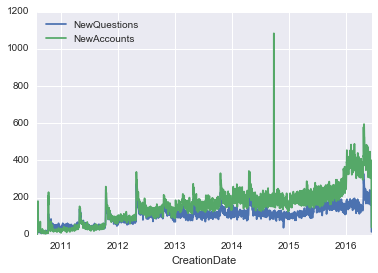

In [45]:
# %matplotlib qt
pd_joined_data_df.plot(x = "CreationDate")

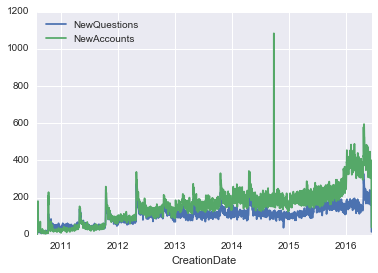

In [46]:
%matplotlib inline
pd_joined_data_df.plot(x = "CreationDate")

### Observation
There is a very high positive correlation between the two curves as can be seen from the graph and the calculated values.